# Demo for SENSE Reconstruction

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.data import shepp_logan_phantom
from sigpy.mri.sim import birdcage_maps
from scipy.ndimage import label

from sense import *

/home/csrao/miniconda3/envs/mcr_gcs/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Utils

In [2]:
def set_background_sensitivity_to_zero(csm, image_gt):
    image_copy = image_gt.copy()
    image_copy[100:300, 100:300] = 1
    labelmap, _ = label(image_copy > 0)
    fg = labelmap != 0
    csm = fg * csm
    return csm

def rss_combine(coil_images):
    return np.sqrt(np.sum(coil_images ** 2, axis=0))

def imshow(ndarray, ax=None, title=''):
    show = False
    if ax is None:
        show = True
        ax = plt.gca()
    ax.imshow(np.squeeze(ndarray), cmap='gray')
    ax.set_axis_off()
    ax.set_title(title)
    if show: plt.show()

### Load data

In [3]:
# Settings

NUM_COILS = 5
ACCELERATION = 4

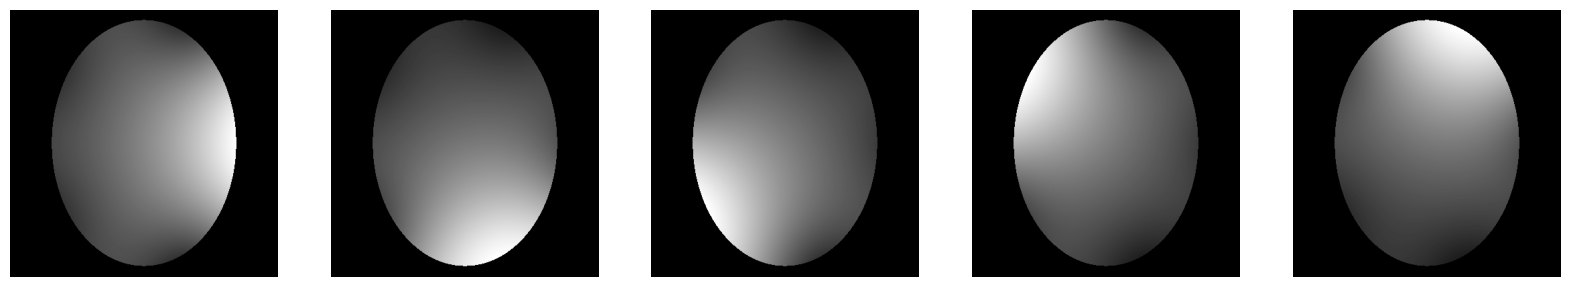

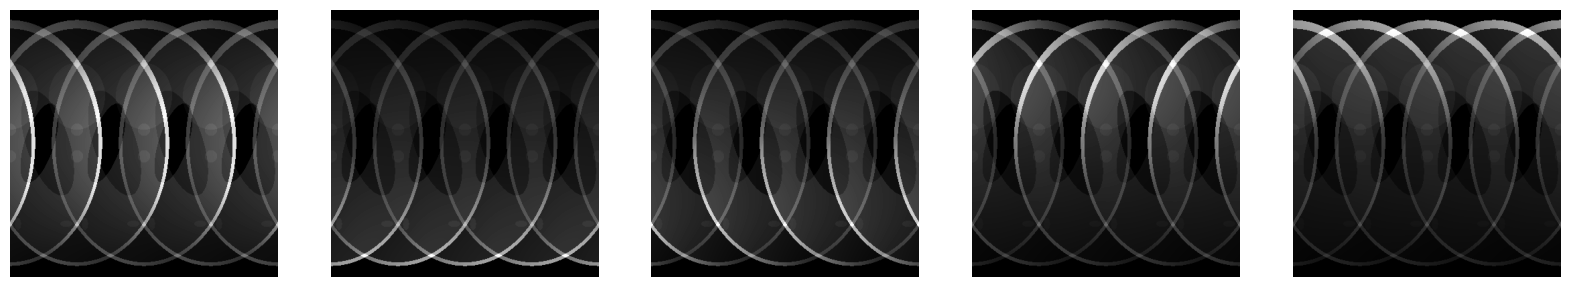

In [4]:
image_gt = shepp_logan_phantom().astype(np.float64)  # Shape format (H,W)

# Simulate CSMs
csm = birdcage_maps((NUM_COILS, 400, 400), r=1.1, dtype=np.complex128)  # Shape format (C,H,W)

# Estimate foreground mask and restrict CSMs to foreground
csm = set_background_sensitivity_to_zero(csm, image_gt)

# Display CSMs
fig, axs = plt.subplots(1, NUM_COILS, figsize=(NUM_COILS*4, 4))
for c in range(NUM_COILS):
    imshow(np.abs(csm[c, :, :]), ax=axs[c])
plt.show()

# Simulate multi-coil data
mask = np.zeros_like(image_gt, dtype=np.int8)  # Shape format (C,H,W)
mask[:, ::ACCELERATION] = 1
kspace_data = fft2c(image_gt * csm) * mask

coil_images = ifft2c(kspace_data)  # Shape format (C,H,W)
fig, axs = plt.subplots(1, NUM_COILS, figsize=(NUM_COILS*4, 4))
for c in range(NUM_COILS):
    imshow(np.abs(coil_images[c, :, :]), ax=axs[c])
plt.show()

### Reconstruction

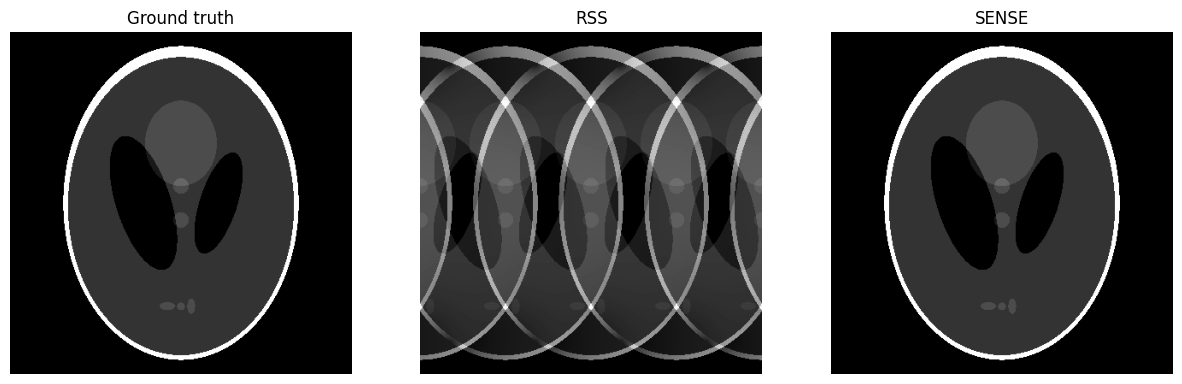

In [5]:
coil_images = ifft2c(kspace_data)

# RSS coil-combination (baseline)
image_rss = rss_combine(ifft2c(kspace_data))

# SENSE coil-combination
image_sense = sense_vectorized(coil_images, csm, ACCELERATION)

# Display
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
imshow(np.abs(image_gt), axs[0], "Ground truth")
imshow(np.abs(image_rss), axs[1], "RSS")
imshow(np.abs(image_sense), axs[2], "SENSE")